### Подключение библиотек и скриптов

In [3]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

**Определяем функции**

In [5]:
# Вычисление персентилей (для функции .agg)
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [6]:
# Уменьшение объёма памяти, занимаемого датасетом
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(deep=True).sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    """
    # Что делает функция?
    
    # Parameters

    # Returns

    """
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

**Пути к директориям и файлам**

In [8]:
TRAIN_DATASET_PATH = 'C:/Users/Данила/Documents/Data science/Python библиотеки/project_task/train.csv'
TEST_DATASET_PATH = 'C:/Users/Данила/Documents/Data science/Python библиотеки/project_task/test.csv'
PREDICTED_DATASET_PATH = 'C:/Users/Данила/Documents/Data science/Python библиотеки/project_task/DDugin_predictions.csv'

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [10]:
train_df.shape

(10000, 20)

In [11]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [12]:
test_df.shape

(5000, 19)

### Приведение типов

In [13]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [14]:
test_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
dtype: object

In [15]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['Rooms'] = train_df['Rooms'].astype('int')

In [16]:
test_df['DistrictId'] = test_df['DistrictId'].astype(str)
test_df['Rooms'] = test_df['Rooms'].astype('int')

In [17]:
df = reduce_mem_usage(train_df)

Memory usage of dataframe is 3.40 MB
Memory usage after optimization is: 0.48 MB
Decreased by 85.9%


In [18]:
df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1.66 MB
Memory usage after optimization is: 0.22 MB
Decreased by 86.7%


### Обзор данных

#### Целевая переменная

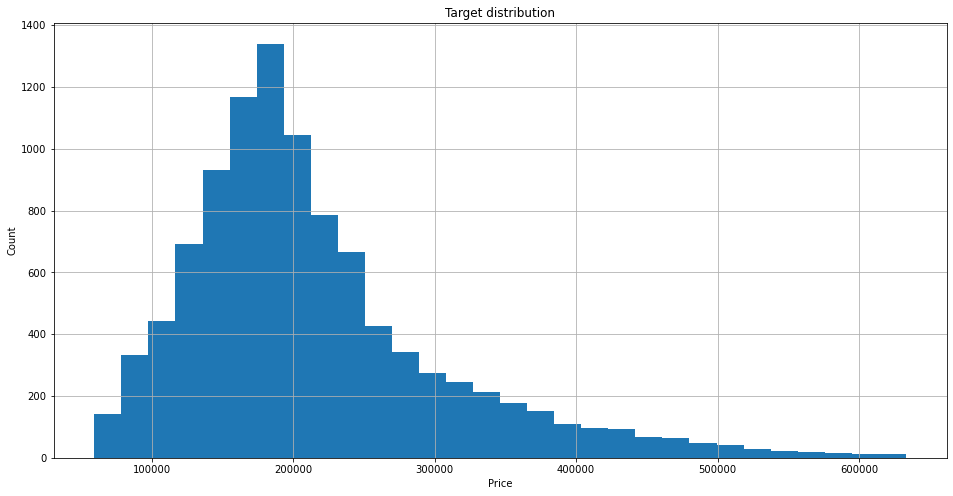

In [19]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

**Количественные переменные**

In [20]:
train_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,0.839512,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [21]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  category
 2   Rooms          10000 non-null  int8    
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [22]:
test_df.describe()

,Id,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,1.910000,56.449501,36.158760,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,0.838594,19.092793,17.825277,9.950147,5.483228,6.789167,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744995,1.47994,4.777365
min,1.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [23]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   category
 2   Rooms          5000 non-null   int8    
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

**Категориальные переменные**

In [24]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

[]

In [25]:
for cat_colname in cat_colnames[1:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

### Обработка выбросов

**Rooms**

In [26]:
train_df['Rooms'].value_counts().sort_index()

0        8
1     3705
2     3880
3     2235
4      150
5       18
6        1
10       2
19       1
Name: Rooms, dtype: int64

In [27]:
train_df[train_df['Rooms'].isin([6, 10, 19])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.312500
1454,8491,1,19,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.617188
2170,14003,99,6,59.414333,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.968750
8849,14865,9,10,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B,172329.265625


In [28]:
train_df[train_df['Rooms'].isin([6, 10, 19])].groupby("Rooms").agg({"Square": "mean", "LifeSquare": "mean", "Price": "mean"})

,Square,LifeSquare,Price
Rooms,,,
6,59.414333,38.702244,229661.968750
10,59.964119,37.321877,244797.281250
19,42.006046,21.779287,78364.617188


In [29]:
train_df.groupby("Rooms").agg({"Square": ["mean", percentile(25), percentile(75)], "LifeSquare": ["mean", percentile(25), percentile(75)], "Price": ["mean", percentile(25), percentile(75)]})

Square                             LifeSquare                \
             mean percentile_25 percentile_75       mean percentile_25   
Rooms                                                                    
0       81.620361     41.017441    100.428886  90.558075           NaN   
1       41.323277     36.692589     43.565369  25.159008           NaN   
2       56.788212     47.873234     63.324703  35.971893           NaN   
3       76.903236     65.995697     83.215958  54.942867           NaN   
4       98.377541     84.053101    104.655212  65.667068           NaN   
5      122.614944     98.727493    124.094322  89.445709           NaN   
6       59.414333     59.414333     59.414333  38.702244     38.702244   
10      59.964119     59.510548     60.417694  37.321877     36.772476   
19      42.006046     42.006046     42.006046  21.779287     21.779287   

                             Price                                
      percentile_75           mean  percentile_25  percentile_75  
Rooms                                                             
0               NaN  200435.890625  150897.812500  231560.125000  
1               NaN  159850.796875  128711.101562  182212.203125  
2               NaN  215256.312500  174516.718750  243492.281250  
3               NaN  289337.968750  218501.031250  349766.968750  
4               NaN  383251.093750  299614.281250  465675.125000  
5               NaN  410431.593750  319145.093750  491901.281250  
6         38.702244  229661.968750  229661.968750  229661.968750  
10        37.871277  244797.281250  208563.281250  281031.312500  
19        21.779287   78364.617188   78364.617188   78364.617188

In [30]:
train_df.loc[train_df['Rooms'] == 10, 'Rooms'] = 2
train_df.loc[train_df['Rooms'] == 19, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] == 6, 'Rooms'] = 2

In [31]:
test_df['Rooms'].value_counts().sort_index()

0        2
1     1769
2     2030
3     1099
4       90
5        7
6        2
17       1
Name: Rooms, dtype: int64

In [32]:
test_df[test_df['Rooms'].isin([6, 17])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2071,10793,23,6,110.750229,NaN,0.0,2,2.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B
3217,4058,27,6,223.453690,104.113556,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
3398,1435,111,17,52.866108,32.528343,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [33]:
test_df.loc[test_df['Rooms'] == 17, 'Rooms'] = 2
test_df.loc[test_df['Rooms'] == 6, 'Rooms'] = 5

In [34]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.750000
1981,7917,27,0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.250000
2269,7317,27,0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976562
3911,770,28,0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.343750
4366,456,6,0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.796875
4853,3224,27,0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.945312
6149,3159,88,0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.109375
8834,9443,27,0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.921875


In [35]:
train_df.loc[train_df['Id'].isin([7317, 770, 3159]), 'Rooms'] = 1
train_df.loc[train_df['Id'] == 456, 'Rooms'] = 3
train_df.loc[train_df['Id'] == 9443, 'Rooms'] = 4
train_df.loc[train_df['Id'].isin([12638, 7917]), 'Rooms'] = 5
train_df.drop(4853, inplace = True) # Вероятно, доля в квартире. Поскольку в test таких квартир нет, то удаляем как выброс

In [36]:
test_df[test_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0,116.824203,113.692421,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0,76.345154,42.820797,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [37]:
test_df.loc[test_df['Id'] == 3343, 'Rooms'] = 5
test_df.loc[test_df['Id'] == 10729, 'Rooms'] = 3

Замена выбросов в Rooms произведена в ручном режиме. Это очень плохо, но, учитывая малое количество выбросов, написание и проверка работы функции займет больше времени, чем обработка выбросов вручную. Основная идея - сравнить общую и жилую площади и цены выбросов с данными, разбитыми по числу комнат. Этот метод все равно не объясняет гигантских площадей для отдельных квартир (более 100 кв.м). Возможно, гигантские площади - пентхаусы либо объединенные и перепланированные квартиры.

**Square, LifeSquare, KitchenSquare**

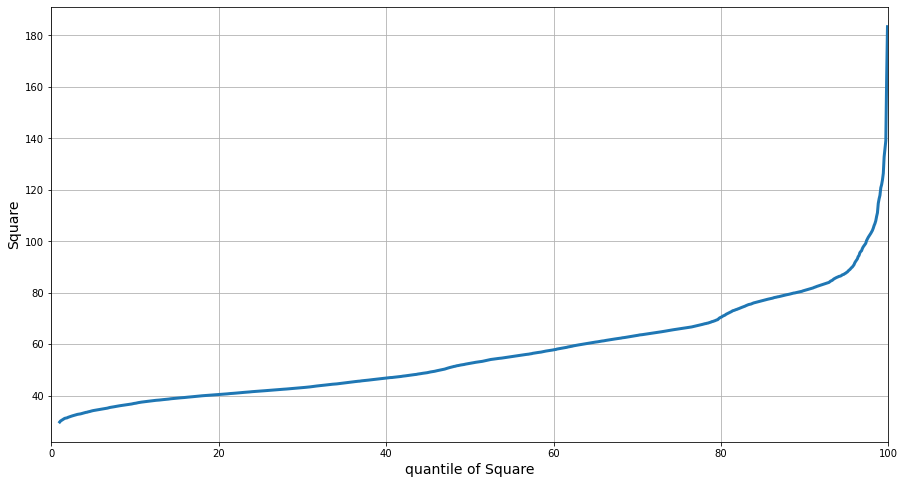

In [38]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(train_df["Square"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of Square", size=14)
plt.ylabel("Square", size=14)
plt.xlim(0, 100)
plt.grid()

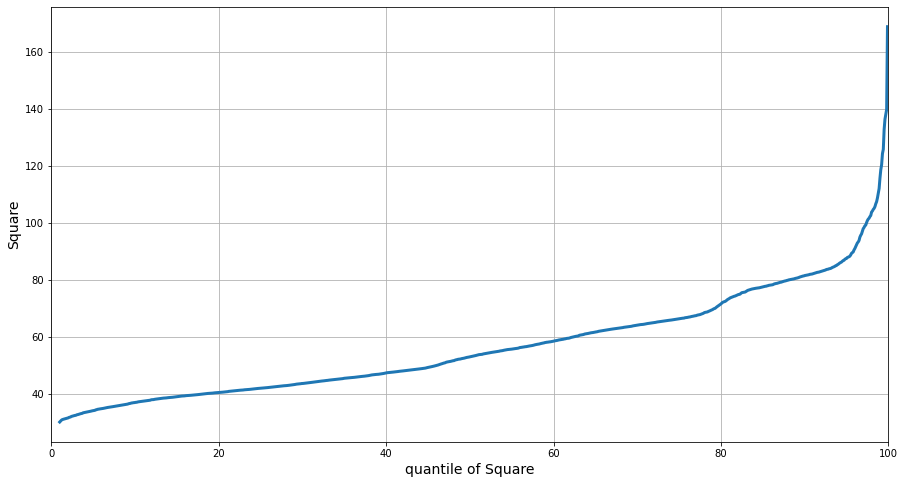

In [39]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(test_df["Square"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of Square", size=14)
plt.ylabel("Square", size=14)
plt.xlim(0, 100)
plt.grid()

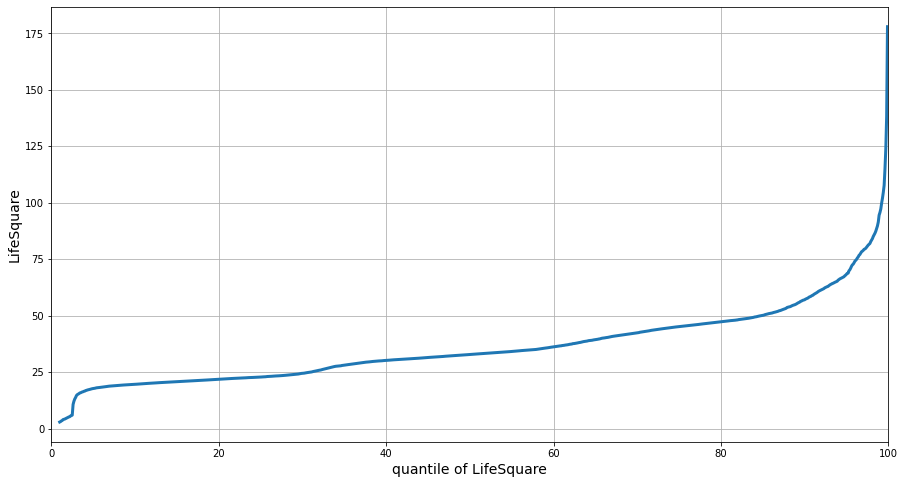

In [40]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(train_df["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of LifeSquare", size=14)
plt.ylabel("LifeSquare", size=14)
plt.xlim(0, 100)
plt.grid()

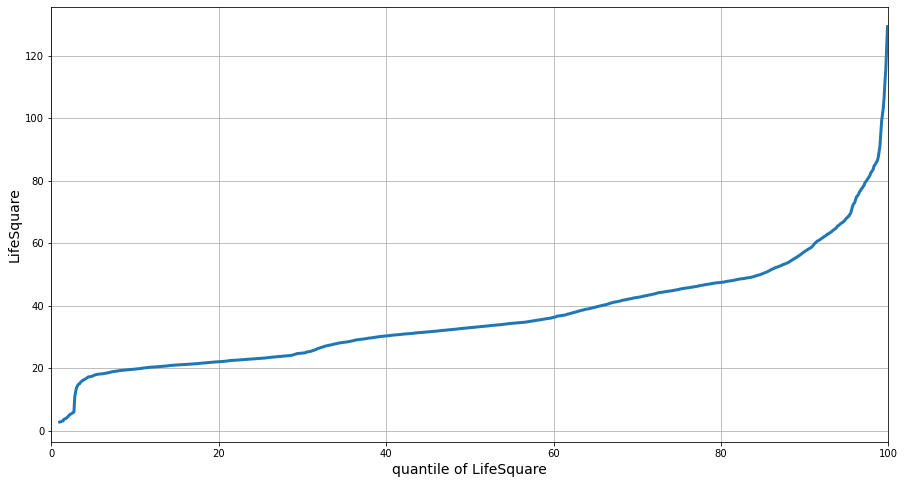

In [41]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(test_df["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of LifeSquare", size=14)
plt.ylabel("LifeSquare", size=14)
plt.xlim(0, 100)
plt.grid()

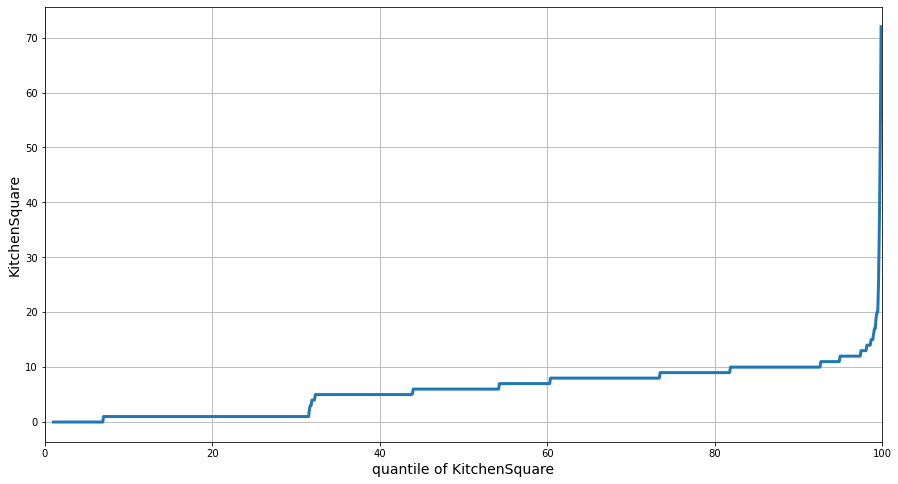

In [42]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(train_df["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of KitchenSquare", size=14)
plt.ylabel("KitchenSquare", size=14)
plt.xlim(0, 100)
plt.grid()

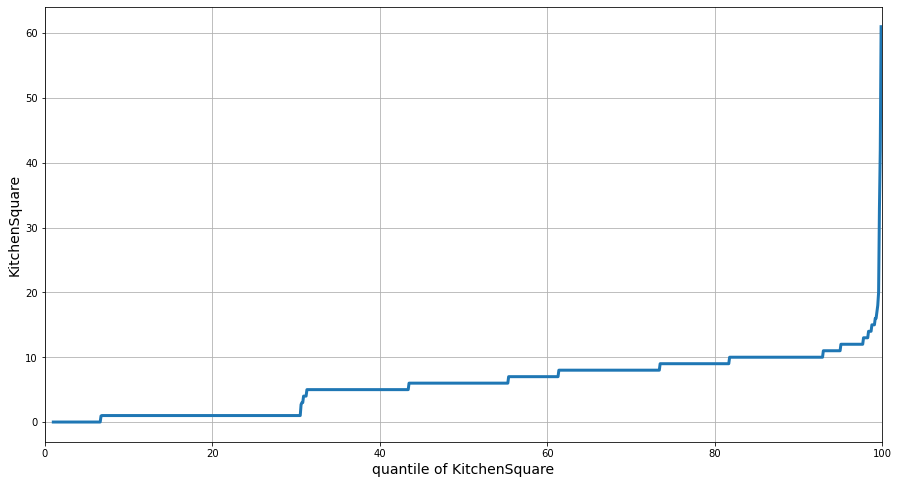

In [43]:
fig = plt.figure(figsize=(15, 8))
q = [np.percentile(test_df["KitchenSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of KitchenSquare", size=14)
plt.ylabel("KitchenSquare", size=14)
plt.xlim(0, 100)
plt.grid()

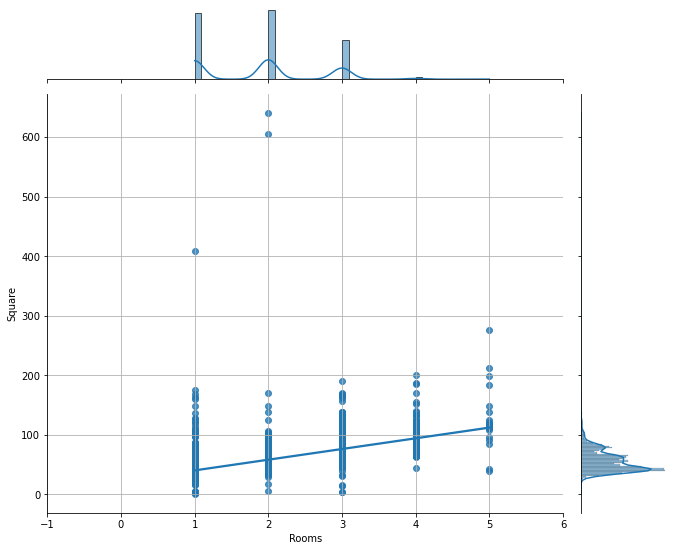

In [44]:
grid = sns.jointplot(
    'Rooms', 'Square', data=train_df, kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(8)
plt.xlim(-1, 6)
plt.grid()
plt.show()

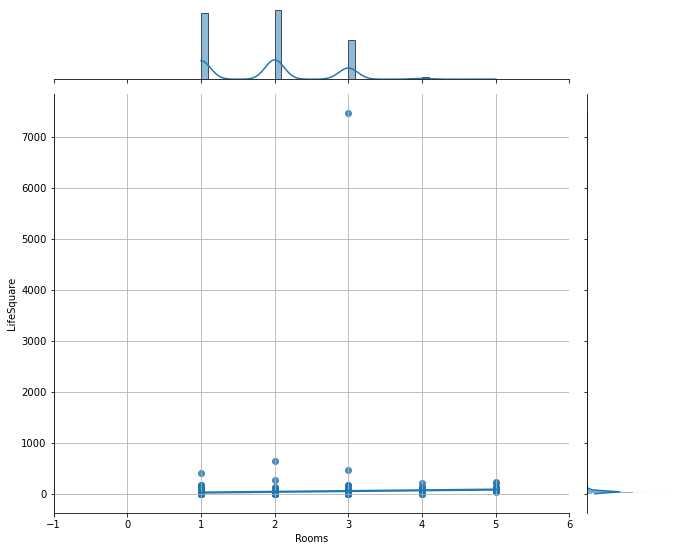

In [45]:
grid = sns.jointplot(
    'Rooms', 'LifeSquare', data=train_df, kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(8)
plt.xlim(-1, 6)
plt.grid()
plt.show()

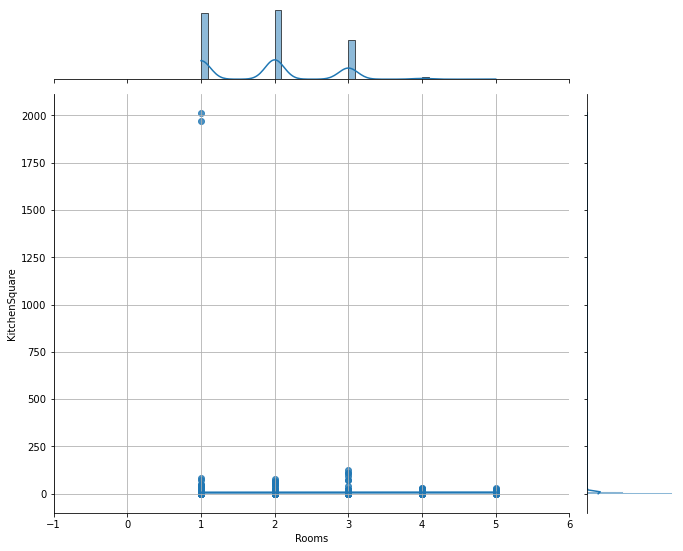

In [46]:
grid = sns.jointplot(
    'Rooms', 'KitchenSquare', data=train_df, kind='reg')
grid.fig.set_figwidth(10)
grid.fig.set_figheight(8)
plt.xlim(-1, 6)
plt.grid()
plt.show()

Заменяем выбросы по площади на медиану для квартир той же комнатности.

Для тренировочной выборки выбросом будем считать общую площадь - более 200 кв.м.

In [47]:
agg_dict = {"Square": ["median"], "LifeSquare": ["median"], "KitchenSquare": ["median"]}
stats = train_df.groupby("Rooms").agg(agg_dict)
stats.columns = [
    f"{raw_feature}" for raw_feature in agg_dict
]
stats.reset_index()
outlier = {"Square": 201, "LifeSquare": 80, "KitchenSquare": 15}

In [48]:
mask_0 = (train_df['Square'] > 201) & (train_df['Rooms'] == 0)
train_df.loc[mask_0, 'Square'] = 81.491447
mask_1 = (train_df['Square'] > 201) & (train_df['Rooms'] == 1)
train_df.loc[mask_1, 'Square'] = 40.408249
mask_2 = (train_df['Square'] > 201) & (train_df['Rooms'] == 2)
train_df.loc[mask_2, 'Square'] = 55.851315
mask_3 = (train_df['Square'] > 201) & (train_df['Rooms'] == 3)
train_df.loc[mask_3, 'Square'] = 77.413643
mask_4 = (train_df['Square'] > 201) & (train_df['Rooms'] == 4)
train_df.loc[mask_4, 'Square'] = 98.668060
mask_5 = (train_df['Square'] > 201) & (train_df['Rooms'] == 5)
train_df.loc[mask_5, 'Square'] = 116.084862

In [49]:
train_df.drop(['LifeSquare'], axis = 1, inplace=True)
train_df.drop(['KitchenSquare'], axis = 1, inplace=True)

Для тестовой выборки выбросом считаем площадь квартиры более 150 кв.м.

In [50]:
mask_0 = (test_df['Square'] > 150) & (test_df['Rooms'] == 0)
test_df.loc[mask_0, 'Square'] = 81.491447
mask_1 = (test_df['Square'] > 150) & (test_df['Rooms'] == 1)
test_df.loc[mask_1, 'Square'] = 40.408249
mask_2 = (test_df['Square'] > 150) & (test_df['Rooms'] == 2)
test_df.loc[mask_2, 'Square'] = 55.851315
mask_3 = (test_df['Square'] > 150) & (test_df['Rooms'] == 3)
test_df.loc[mask_3, 'Square'] = 77.413643
mask_4 = (test_df['Square'] > 150) & (test_df['Rooms'] == 4)
test_df.loc[mask_4, 'Square'] = 98.668060
mask_5 = (test_df['Square'] > 150) & (test_df['Rooms'] == 5)
test_df.loc[mask_5, 'Square'] = 116.084862

In [51]:
test_df.drop(['LifeSquare'], axis = 1, inplace=True)
test_df.drop(['KitchenSquare'], axis = 1, inplace=True)

**Years**

In [52]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
6735        2020
4493        2020
4053        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 9999, dtype: int32

In [53]:
train_df.loc[train_df['HouseYear'] == 4968, 'HouseYear'] = 1968
train_df.loc[train_df['HouseYear'] == 20052011, 'HouseYear'] = 2005

In [54]:
test_df['HouseYear'].sort_values(ascending=False)

4389    2020
4273    2020
888     2020
3255    2020
1039    2020
        ... 
1475    1912
64      1911
2691    1910
2       1909
3253    1908
Name: HouseYear, Length: 5000, dtype: int16

**Создаем новый признак**

In [55]:
train_df['Type_floor'] = 0
train_df.loc[train_df['Floor'] == 0, 'Type_floor'] = 1
mask_f = train_df['Floor'] == train_df['HouseFloor']
train_df.loc[mask_f, 'Type_floor'] = 1

In [56]:
test_df['Type_floor'] = 0
test_df.loc[test_df['Floor'] == 0, 'Type_floor'] = 1
mask_f = test_df['Floor'] == test_df['HouseFloor']
test_df.loc[mask_f, 'Type_floor'] = 1

In [57]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [58]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

**Разбиение на train и valid**

In [59]:
feature_names = ['Rooms', 'Square', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin', 'Type_floor']
target_name = 'Price'
X = train_df[feature_names]
y = train_df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

**Обучение модели**

In [60]:
rf_model = RandomForestRegressor(max_depth=8, n_estimators=100, random_state=21)
rf_model.fit(X_train.fillna(-9999), y_train)

RandomForestRegressor(max_depth=8, random_state=21)

Train R2:	0.789
Test R2:	0.68


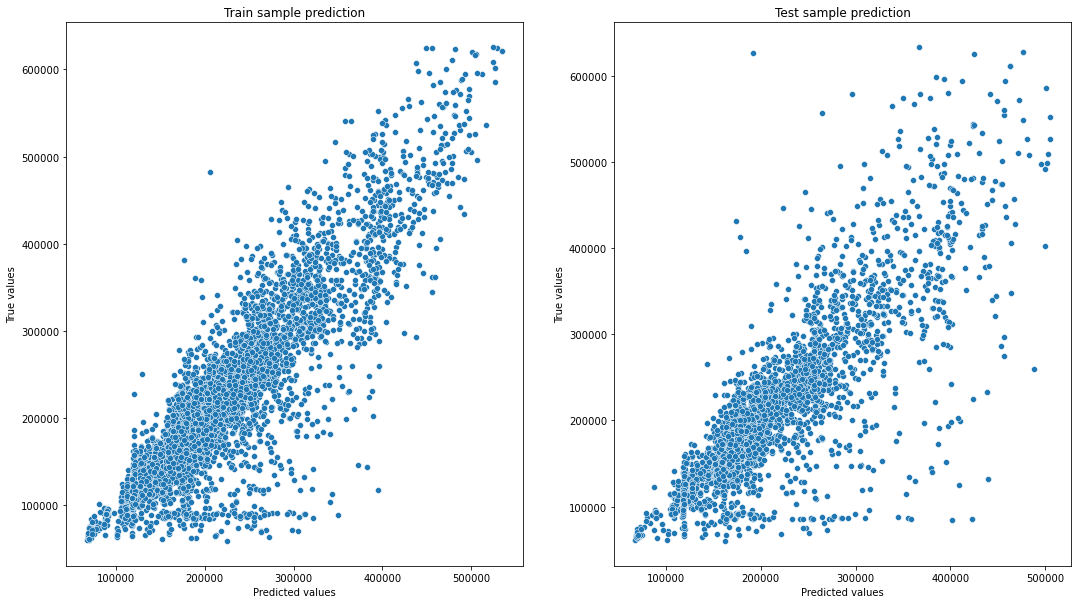

In [61]:
y_train_preds = rf_model.predict(X_train.fillna(-9999))
y_valid_preds = rf_model.predict(X_valid.fillna(-9999))
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)

In [75]:
x_test = test_df[feature_names]
Y_pred = test_df['Id']

In [76]:
Y_pred['Price'] = rf_model.predict(x_test.fillna(-999))

### Сохранение результатов

In [77]:
Y_pred.to_csv(PREDICTED_DATASET_PATH, index=False, encoding='utf-8', sep=';')